In [1]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import uproot
import awkward as ak
%matplotlib inline

from sklearn.preprocessing import RobustScaler

# import basic libraries 
import h5py
import pandas as pd

from keras.models import Model
from keras.layers import Input, add
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.layers import Layer, Dense, Dropout, Activation, Flatten, Reshape
from keras import regularizers
from keras.regularizers import l2
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.utils import np_utils


2024-06-24 15:07:49.833453: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e06451d4329e3ea47/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/cvmfs/cms.cern.ch/el9_amd64_gcc12/external/py3-numpy/1.24.3-a3a65cbc18c6a98e0645

In [2]:
#Opening file
filename = "/uscms/home/jpearkes/eos/forAda/scouting_nano.root" # originally from root://hip-cms-se.csc.fi//store/user/pinkaew/scouting_nano_prod_golden/ScoutingPFRun3/crab_ScoutingPFRun3_Run2024D-v1_380385-380470_Golden/240517_205837/0000/scouting_nano_399.root
file = uproot.open(filename)

#Calling files
jet_pt = file["Events"]["L1Jet_pt"].array()
jet_eta = file["Events"]["L1Jet_eta"].array()
jet_phi = file["Events"]["L1Jet_phi"].array()



In [3]:
jet_pt = np.asarray(ak.fill_none(ak.pad_none(jet_pt, 4, clip=True), 0.0)) #replace missing values with none, increase value to target length with ak.pad_none
jet_eta = np.asarray(ak.fill_none(ak.pad_none(jet_eta, 4, clip=True), 0.0))
jet_phi = np.asarray(ak.fill_none(ak.pad_none(jet_phi, 4, clip=True), 0.0))

jet_eta.shape #np function that gives us shape of array - (rows, columns) - 4 columns bc we said so with ak.pad_none

(431555, 4)

In [4]:
dataset = np.hstack([jet_pt,jet_eta,jet_phi]) #puts all the arrays next to eachother
dataset

array([[ 2.30000000e+01,  2.20000000e+01,  1.80000000e+01, ...,
        -4.10705566e-01, -1.36767578e+00,  1.87060547e+00],
       [ 1.60000000e+01,  1.20000000e+01,  1.15000000e+01, ...,
         8.26538086e-01, -2.84667969e+00,  7.39501953e-01],
       [ 2.00000000e+01,  1.35000000e+01,  1.90000000e+01, ...,
        -6.26831055e-02,  1.34838867e+00,  2.47949219e+00],
       ...,
       [ 2.80000000e+01,  2.55000000e+01,  1.85000000e+01, ...,
        -1.01977539e+00,  2.91455078e+00,  3.91479492e-01],
       [ 2.14500000e+02,  9.70000000e+01,  8.10000000e+01, ...,
         3.04504395e-01,  1.52246094e+00,  5.65551758e-01],
       [ 2.15000000e+01,  1.90000000e+01,  1.90000000e+01, ...,
        -1.62866211e+00,  1.34838867e+00, -1.71557617e+00]])

In [5]:
# We want some data for training, some for validating, and some for testing
# Validating combats overfitting while testing analyzes the predictive power of the network
dataset_size = dataset.shape[0] #gives you number of rows
data_train = dataset[0:int(dataset_size/2)] #50%
data_valid = dataset[int(dataset_size/2):int(dataset_size/4*3)] # 25% - used for tuning hyper-parameters
data_test = dataset[int(dataset_size/4*3):] # 25% - hold out for now

print(data_train.shape,data_test.shape, data_valid.shape)

(215777, 12) (107889, 12) (107889, 12)


In [6]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        print(batch)
        dim = tf.shape(z_mean)[1]
        print(dim)
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
#Encoder

latent_dim = 4

encoder_inputs = keras.Input(shape=(12))
x = layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = False)(encoder_inputs)
x1 = layers.Dense(32, activation="relu")(x)
x2 = layers.Dense(16, activation="relu")(x1)
x3 = layers.Dense(8, activation="relu")(x2)
z_mean = layers.Dense(latent_dim, name="z_mean")(x3)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x3)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x4 = layers.Dense(16, activation="relu")(latent_inputs)
norm_layer_1 = layers.BatchNormalization(name="norm_1")(x4)
x5 = layers.Dense(32, activation="relu")(norm_layer_1)
norm_layer_2 = layers.BatchNormalization(name="norm_2")(x5)
x6 = layers.Dense(64, activation="relu")(norm_layer_2)
norm_layer_3 = layers.BatchNormalization(name="norm_3")(x6)
x7 = layers.Dense(128, activation="relu")(norm_layer_3)
x8 = layers.Dense(12,kernel_initializer='zeros', activation='linear')(x7)
decoder_outputs = tf.keras.layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = True)(x8)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

#Build Model

class VAE(keras.Model):
    def __init__(self, encoder, decoder,alpha = 1, beta = 0.001, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        self.reco_scale = alpha * (1 - beta)
        self.kl_scale = beta
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.total_val_loss_tracker = keras.metrics.Mean(name="total_val_loss")
        self.reconstruction_val_loss_tracker = keras.metrics.Mean(name="val_reco_loss")
        self.kl_val_loss_tracker = keras.metrics.Mean(name="val_kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    

    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #MSE = keras.losses.MeanSquaredLogarithmicError(reduction="auto", name="mean_squared_error")
            #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
            MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
            reconstruction_loss = self.reco_scale * tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
        MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
        reconstruction_loss = self.reco_scale* tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
                    
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss
        
        self.total_val_loss_tracker.update_state(total_loss)
        self.reconstruction_val_loss_tracker.update_state(reconstruction_loss)
        self.kl_val_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_val_loss_tracker.result(),
            "reco_loss": self.reconstruction_val_loss_tracker.result(),
            "kl_loss": self.kl_val_loss_tracker.result()

      }

Tensor("sampling/strided_slice:0", shape=(), dtype=int32)
Tensor("sampling/strided_slice_1:0", shape=(), dtype=int32)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 normalization (Normalization)  (None, 12)           0           ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 32)           416         ['normalization[0][0]']          
                                                                                                  
 dense_1 (Dense)                (None, 16)           528         ['dense[

In [7]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5, verbose = 1,restore_best_weights=True)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001,clipnorm=10.0))
history = vae.fit(data_train, validation_data = (data_valid, data_valid), epochs=10, batch_size=16, callbacks = [callback],shuffle=False)

Epoch 1/10
Tensor("encoder/sampling/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling/strided_slice_1:0", shape=(), dtype=int32)
Tensor("encoder/sampling/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling/strided_slice_1:0", shape=(), dtype=int32)
13458/13487 [============================>.] - ETA: 0s - loss: 961512693.6665 - reconstruction_loss: 1062204928.0000 - kl_loss: 15118064.0000Tensor("encoder/sampling/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling/strided_slice_1:0", shape=(), dtype=int32)
13487/13487 [==============================] - 28s 2ms/step - loss: 961767529.0774 - reconstruction_loss: 1059920960.0000 - kl_loss: 15085557.0000 - val_loss: 282.6385 - val_reco_loss: 282.2099 - val_kl_loss: 0.4288
Epoch 2/10
13487/13487 [==============================] - 24s 2ms/step - loss: 207.7846 - reconstruction_loss: 156.2800 - kl_loss: 0.4248 - val_loss: 191.2271 - val_reco_loss: 190.7962 - val_kl_loss: 0.4306
Epoch 3/10
13487/13487 

In [8]:
z_mean, z_log_var, z = vae.encoder.predict(data_valid)
output = vae.decoder.predict(z)

Tensor("encoder/sampling/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling/strided_slice_1:0", shape=(), dtype=int32)
3372/3372 [==============================] - 3s 748us/step


dict_keys(['loss', 'reconstruction_loss', 'kl_loss', 'val_loss', 'val_reco_loss', 'val_kl_loss'])


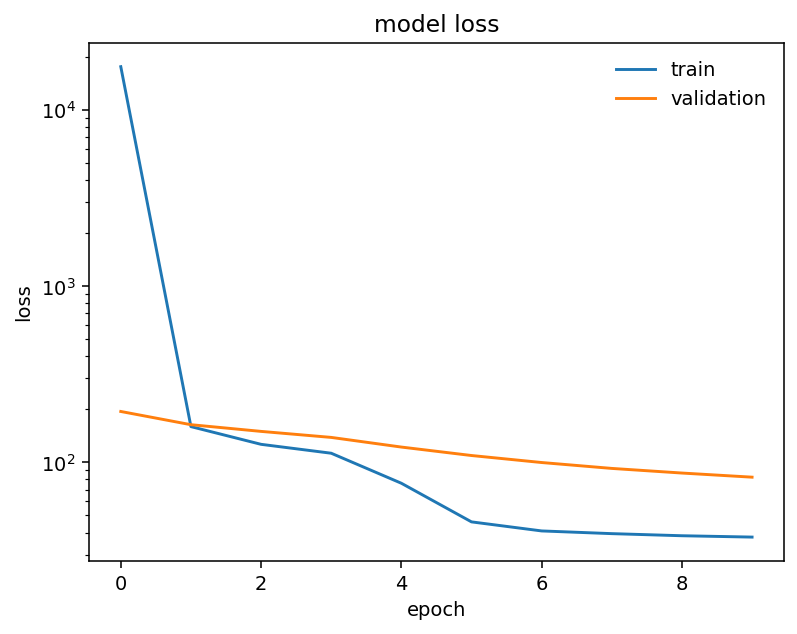

In [43]:
print(history.history.keys())

plt.plot(history.history['loss'],label="train")
plt.plot(history.history['val_loss'],label="validation")
#plt.yscale('log')
plt.title('model loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper right',frameon = False)
plt.show()


(107889, 4, 3) (107889, 12) (107889, 12)


Text(0.5, 1.0, '1st Jet')

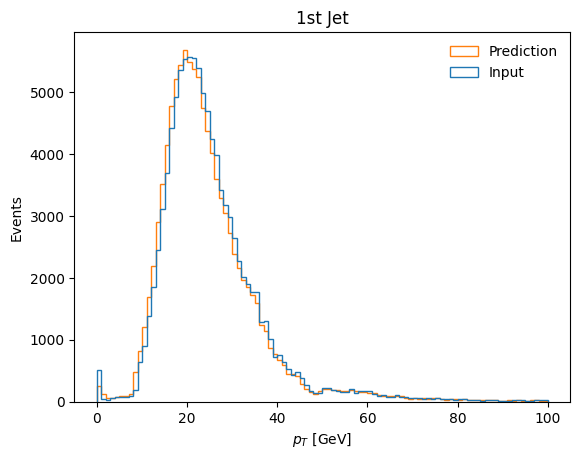

In [9]:
decoded_data = output.reshape(output.shape[0], 4,3) # Do the three dimensions correspond to the three variables? Bc I feel like no
data_valid_reshaped = data_valid.reshape(data_valid.shape[0], 4,3)

print(decoded_data.shape,data_test.shape, data_valid.shape)

#Jet Pt plot
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,0,0],decoded_data[:,0,0]],bins=100,histtype='step',range = (0,100), label = ['Input','Prediction'])
plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')

#But hey this looks great!

# Notes

**Might need to check the dataset shapes here**

Everything ran fine, with the exception of the model loss? It seems odd that validation = 0 for so much longer than training period.

**What is the training step doing?** 

The training step relies on the 50% of data that we set aside in the beginning. We've defined a loss function that we want to minimize (I assume) and the Gradient Tape gives us more control over the layer we've defined ([Source](https://stackoverflow.com/questions/53953099/what-is-the-purpose-of-the-tensorflow-gradient-tape)). The "trainable weights" change throughout the process so as to minimize loss.

How do the trainable weights actually change? Just it just try out a bunch of different configurations?

**What are hyperparameters and what happen when you change them?** 

Hyperparameters are settings that determine how the neural networks learn ([Source](https://pyimagesearch.com/2021/05/31/hyperparameter-tuning-for-deep-learning-with-scikit-learn-keras-and-tensorflow/)). Here, we have qualities like learning rate, batch size, and number of epochs.
- Patience: How many epochs to continue running even if model is not improving ([Source](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/))
- Verbose: When verbose = 1, program will return the number of the epoch that the network stopped at (Source above). 
- Epochs: Increasing the epoch size gives the program more training opportunities, thereby minimizing the loss even more. However, it does increase computation time. I increased the epoch size to 15, and it stopped it after 7/15 runs, with a 37.1% loss. However, this was also considering the training from the last 10 epochs. When I graphed the model loss, train decreased while validation increased.
- Learning rate: Changing the learning rate from 0.0001 to 0.1 had massively high loss rates (Epoch 2/10 had about 34200) and disastrous correlation on the 1st jet plot. I imagine that making the learning rate smaller would give better results, but take very long. 
- Batch Size: Resetting learning rate and changing the batch size from 16 to 8 increased the computation time and also had pretty bad loss (although, this could be from the aftermath of the learning rate). 

**How well does the input compare with the predictions?** 

With the given hyperparameters, very well! There is a peak in the input at ~0 GeV that is unanticipated, but beyond that, there is high correlation - is there a way to statistically back this up?

**What is overtraining and how can you combat it?** 

Overtraining is when the network becomes too accustomed to the data set and bases its actions on the specifics of the set, rather on the general traits that would allow it to make predictions. ([Source](https://www.allaboutcircuits.com/technical-articles/understanding-simple-neural-network-training-and-learning/#:~:text=Neural%20networks%20can%20respond%20to%20extremely%20complex%20relationships,classification%20task.%20This%20is%20called%20overtraining%20%28or%20overfitting%29.))

**Can you plot eta and phi input vs predictions too?** 

Attempted below! 

**Can you add in electrons and muons into the training too? Do the predictions improve or get worse?** 

One way to find out!

In [131]:
# Struggled to figure out where pt, eta, and phi were in the reshaped data. Assumed:
# pt: [:,0,0], [:,0,1], [:,0,2], [:,1,0]
# eta: [:,1,1], [:,1,2], [:,2,0], [:,2,1]
# phi: [:,2,2], [:,3,0], [:,3,1], [:,3,2]

# Predictions didn't match except for pt, but max and medians were about right

(107889, 4, 3) (107889, 12) (107889, 12)


Text(0.5, 1.0, '1st Jet')

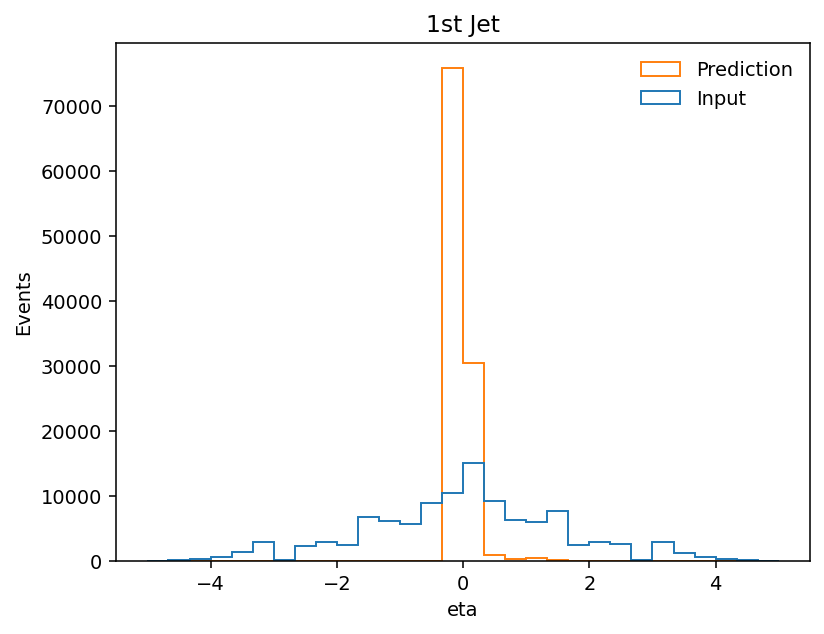

In [35]:
# Eta input vs. predictions
decoded_data = output.reshape(output.shape[0], 4,3)
data_valid_reshaped = data_valid.reshape(data_valid.shape[0], 4,3)

print(decoded_data.shape,data_test.shape, data_valid.shape)

# Prediction isn't great - either model isn't trained well or I am calling the wrong output data
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,2,1],decoded_data[:,2,1]],bins=30,histtype='step',range = (-5,5), label = ['Input','Prediction'])
plt.xlabel(r"eta")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')

(107889, 4, 3) (107889, 12) (107889, 12)


Text(0.5, 1.0, '1st Jet')

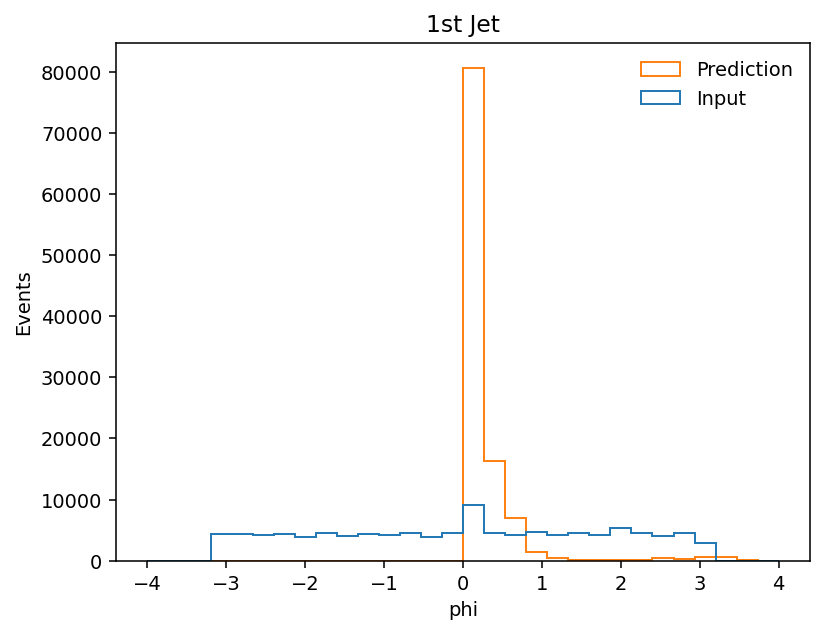

In [36]:
# phi input vs. predictions
decoded_data = output.reshape(output.shape[0], 4,3)
data_valid_reshaped = data_valid.reshape(data_valid.shape[0], 4,3)

print(decoded_data.shape,data_test.shape, data_valid.shape)

# Same thing. [:,0,2] = phi?
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,3,2],decoded_data[:,3,2]],bins=30,histtype='step',range = (-4,4), label = ['Input','Prediction'])
plt.xlabel(r"phi")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')

**Training model with electrons and muons now!** --> actually just muons rn bc I don't know what electrons to use

In [147]:
#Opening file
filename = "/uscms/home/jpearkes/eos/forAda/scouting_nano.root" # originally from root://hip-cms-se.csc.fi//store/user/pinkaew/scouting_nano_prod_golden/ScoutingPFRun3/crab_ScoutingPFRun3_Run2024D-v1_380385-380470_Golden/240517_205837/0000/scouting_nano_399.root
file = uproot.open(filename)

#Calling files
jet_pt = file["Events"]["L1Jet_pt"].array()
jet_eta = file["Events"]["L1Jet_eta"].array()
jet_phi = file["Events"]["L1Jet_phi"].array()
muon_pt = file["Events"]["L1Mu_pt"].array()
muon_eta = file["Events"]["L1Mu_eta"].array()
muon_phi = file["Events"]["L1Mu_phi"].array()


In [148]:
jet_pt = np.asarray(ak.fill_none(ak.pad_none(jet_pt, 4, clip=True), 0.0)) #replace missing values with none, increase value to target length with ak.pad_none
jet_eta = np.asarray(ak.fill_none(ak.pad_none(jet_eta, 4, clip=True), 0.0))
jet_phi = np.asarray(ak.fill_none(ak.pad_none(jet_phi, 4, clip=True), 0.0))
muon_pt = np.asarray(ak.fill_none(ak.pad_none(muon_pt, 4, clip=True), 0.0)) 
muon_eta = np.asarray(ak.fill_none(ak.pad_none(muon_eta, 4, clip=True), 0.0))
muon_phi = np.asarray(ak.fill_none(ak.pad_none(muon_phi, 4, clip=True), 0.0))

In [151]:
dataset = np.hstack([jet_pt,jet_eta,jet_phi,muon_pt,muon_eta,muon_phi]) #puts all the arrays next to eachother

dataset_size = dataset.shape[0] #gives you number of rows
data_train = dataset[0:int(dataset_size/2)] #50%
data_valid = dataset[int(dataset_size/2):int(dataset_size/4*3)] # 25% - used for tuning hyper-parameters
data_test = dataset[int(dataset_size/4*3):] # 25% - hold out for now

print(data_train.shape,data_test.shape, data_valid.shape)

(215777, 24) (107889, 24) (107889, 24)


In [157]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        print(batch)
        dim = tf.shape(z_mean)[1]
        print(dim)
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
#Encoder

latent_dim = 4

encoder_inputs = keras.Input(shape=(24))
x = layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = False)(encoder_inputs)
x1 = layers.Dense(32, activation="relu")(x)
x2 = layers.Dense(16, activation="relu")(x1)
x3 = layers.Dense(8, activation="relu")(x2)
z_mean = layers.Dense(latent_dim, name="z_mean")(x3)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x3)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x4 = layers.Dense(16, activation="relu")(latent_inputs)
norm_layer_1 = layers.BatchNormalization(name="norm_1")(x4)
x5 = layers.Dense(32, activation="relu")(norm_layer_1)
norm_layer_2 = layers.BatchNormalization(name="norm_2")(x5)
x6 = layers.Dense(64, activation="relu")(norm_layer_2)
norm_layer_3 = layers.BatchNormalization(name="norm_3")(x6)
x7 = layers.Dense(128, activation="relu")(norm_layer_3)
x8 = layers.Dense(24,kernel_initializer='zeros', activation='linear')(x7)
decoder_outputs = tf.keras.layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = True)(x8)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

#Build Model

class VAE(keras.Model):
    def __init__(self, encoder, decoder,alpha = 1, beta = 0.001, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        self.reco_scale = alpha * (1 - beta)
        self.kl_scale = beta
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.total_val_loss_tracker = keras.metrics.Mean(name="total_val_loss")
        self.reconstruction_val_loss_tracker = keras.metrics.Mean(name="val_reco_loss")
        self.kl_val_loss_tracker = keras.metrics.Mean(name="val_kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    

    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #MSE = keras.losses.MeanSquaredLogarithmicError(reduction="auto", name="mean_squared_error")
            #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
            MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
            reconstruction_loss = self.reco_scale * tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
        MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
        reconstruction_loss = self.reco_scale* tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
                    
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss
        
        self.total_val_loss_tracker.update_state(total_loss)
        self.reconstruction_val_loss_tracker.update_state(reconstruction_loss)
        self.kl_val_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_val_loss_tracker.result(),
            "reco_loss": self.reconstruction_val_loss_tracker.result(),
            "kl_loss": self.kl_val_loss_tracker.result()

      }

Tensor("sampling_3/strided_slice:0", shape=(), dtype=int32)
Tensor("sampling_3/strided_slice_1:0", shape=(), dtype=int32)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 24)]         0           []                               
                                                                                                  
 normalization_9 (Normalization  (None, 24)          0           ['input_10[0][0]']               
 )                                                                                                
                                                                                                  
 dense_24 (Dense)               (None, 32)           800         ['normalization_9[0][0]']        
                                                                     

In [166]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5, verbose = 1,restore_best_weights=True)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001,clipnorm=10.0))
history = vae.fit(data_train, validation_data = (data_valid, data_valid), epochs=15, batch_size=16, callbacks = [callback],shuffle=False)

Epoch 1/15
Tensor("encoder/sampling_3/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_3/strided_slice_1:0", shape=(), dtype=int32)
Tensor("encoder/sampling_3/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_3/strided_slice_1:0", shape=(), dtype=int32)
13476/13487 [============================>.] - ETA: 0s - loss: 88.1338 - reconstruction_loss: 85.5470 - kl_loss: 0.3497Tensor("encoder/sampling_3/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_3/strided_slice_1:0", shape=(), dtype=int32)
13487/13487 [==============================] - 31s 2ms/step - loss: 88.1318 - reconstruction_loss: 85.5238 - kl_loss: 0.3496 - val_loss: 89.5961 - val_reco_loss: 89.2546 - val_kl_loss: 0.3416
Epoch 2/15
13487/13487 [==============================] - 28s 2ms/step - loss: 85.4123 - reconstruction_loss: 83.1449 - kl_loss: 0.3313 - val_loss: 87.5421 - val_reco_loss: 87.2085 - val_kl_loss: 0.3336
Epoch 3/15
13487/13487 [==============================] - 27s

In [167]:
z_mean, z_log_var, z = vae.encoder.predict(data_valid)
output = vae.decoder.predict(z)

3372/3372 [==============================] - 2s 715us/step


dict_keys(['loss', 'reconstruction_loss', 'kl_loss', 'val_loss', 'val_reco_loss', 'val_kl_loss'])


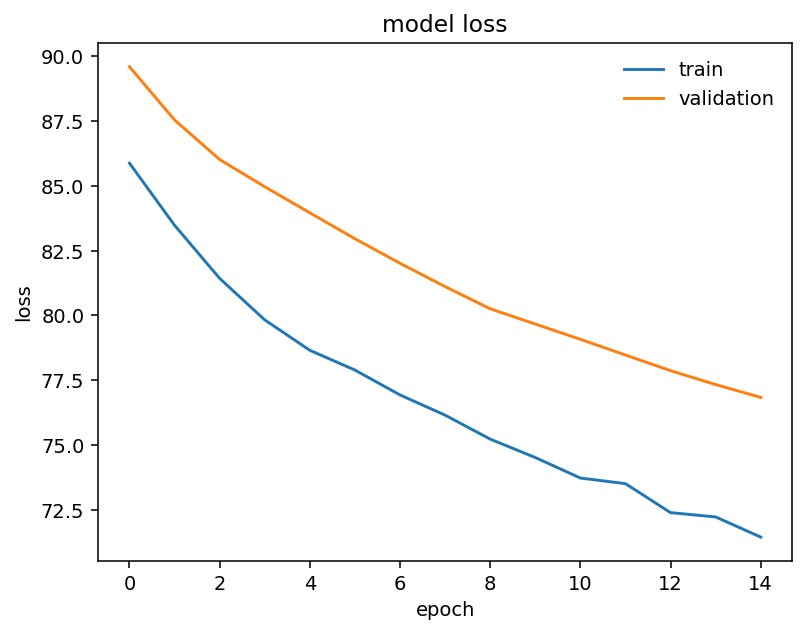

In [168]:
print(history.history.keys())

plt.plot(history.history['loss'],label="train")
plt.plot(history.history['val_loss'],label="validation")
#plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper right',frameon = False)
plt.show()

#This is more the model loss graph I expected above

(107889, 4, 6) (107889, 24) (107889, 24)


Text(0.5, 1.0, '1st Jet')

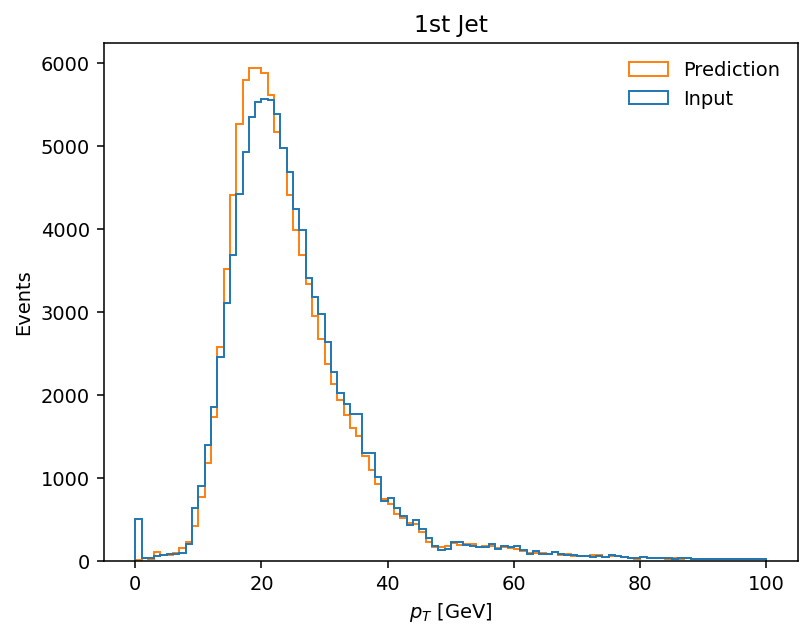

In [170]:
# Need to reshape data slightly differently
decoded_data = output.reshape(output.shape[0], 4,6)
data_valid_reshaped = data_valid.reshape(data_valid.shape[0], 4,6)

print(decoded_data.shape,data_test.shape, data_valid.shape)

#Jet Pt plot
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,0,0],decoded_data[:,0,0]],bins=100,histtype='step',range = (0,100), label = ['Input','Prediction'])
plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')

# Def worse than before! Is the network confusing what applies to jets vs muons? 

## Normalization layer axis = 1
After playing around a little, it was conlcuded that

    layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = False)(encoder_inputs)

is the best configuration, as seen in the original NN. An example of what each axis setting does is given below. [More reading here](https://keras.io/api/layers/preprocessing_layers/numerical/normalization/)

In [20]:
#What do different axises do? Taken from encoder data
print(f"Axis=0 Mean: {np.mean(data_train,axis=0)}\n"
      f"Axis=0 STD: {np.std(data_train,axis=0)}\n"
      f"Axis=0 Length: {len(np.std(data_train,axis=0))}\n"
      f"Axis=1 Mean: {np.mean(data_train,axis=1)}\n"
      f"Axis=1 STD: {np.std(data_train,axis=1)}\n"
      f"Axis=1 Length: {len(np.std(data_train,axis=1))}\n" 
      f"Axis=-1 Mean: {np.mean(data_train,axis=-1)}\n"
      f"Axis=-1 STD: {np.std(data_train,axis=-1)}\n"
      f"Axis=-1 Length: {len(np.std(data_train,axis=-1))}\n"
)

#data_train is a 2D array, so axis=1 and axis=-1 mean the same thing (because axis=-1 gives you the last axis)

Axis=0 Mean: [3.25114887e+01 3.92706428e+01 4.58870640e+01 4.64487805e+01
 2.09819957e-02 3.61361696e-02 2.07537482e-02 2.20828930e-02
 1.07470152e-02 3.18065317e-04 6.09663663e-03 2.15324725e-03]
Axis=0 STD: [59.01165917 80.86258742 90.37975798 86.72260109  1.59043413  1.54185648
  1.52537037  1.51442136  1.81666347  1.81117041  1.79854077  1.77269716]
Axis=0 Length: 12
Axis=1 Mean: [ 6.54389954  4.6267395   6.08380636 ... 23.32105509  6.11964925
  6.05105209]
Axis=1 STD: [ 9.52478261  8.11137815  7.70073064 ... 42.39836755  9.33189837
 11.51392144]
Axis=1 Length: 215777
Axis=-1 Mean: [ 6.54389954  4.6267395   6.08380636 ... 23.32105509  6.11964925
  6.05105209]
Axis=-1 STD: [ 9.52478261  8.11137815  7.70073064 ... 42.39836755  9.33189837
 11.51392144]
Axis=-1 Length: 215777



## Overfitting the Network
Here, we are going to force the network to overtrain. This means many epochs and a high patience, so that it doesn't automatically stop.

In [27]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        print(batch)
        dim = tf.shape(z_mean)[1]
        print(dim)
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
#Encoder

latent_dim = 4

encoder_inputs = keras.Input(shape=(12))
#Change axis = 1 and get rid of axis = -1
x = layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = False)(encoder_inputs)
x1 = layers.Dense(32, activation="relu")(x)
x2 = layers.Dense(16, activation="relu")(x1)
x3 = layers.Dense(8, activation="relu")(x2)
z_mean = layers.Dense(latent_dim, name="z_mean")(x3)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x3)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x4 = layers.Dense(16, activation="relu")(latent_inputs)
norm_layer_1 = layers.BatchNormalization(name="norm_1")(x4)
x5 = layers.Dense(32, activation="relu")(norm_layer_1)
norm_layer_2 = layers.BatchNormalization(name="norm_2")(x5)
x6 = layers.Dense(64, activation="relu")(norm_layer_2)
norm_layer_3 = layers.BatchNormalization(name="norm_3")(x6)
x7 = layers.Dense(128, activation="relu")(norm_layer_3)
x8 = layers.Dense(12,kernel_initializer='zeros', activation='linear')(x7)
decoder_outputs = tf.keras.layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = True)(x8)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

#Build Model

class VAE(keras.Model):
    def __init__(self, encoder, decoder,alpha = 1, beta = 0.001, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        self.reco_scale = alpha * (1 - beta)
        self.kl_scale = beta
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.total_val_loss_tracker = keras.metrics.Mean(name="total_val_loss")
        self.reconstruction_val_loss_tracker = keras.metrics.Mean(name="val_reco_loss")
        self.kl_val_loss_tracker = keras.metrics.Mean(name="val_kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    

    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #MSE = keras.losses.MeanSquaredLogarithmicError(reduction="auto", name="mean_squared_error")
            #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
            MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
            reconstruction_loss = self.reco_scale * tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
        MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
        reconstruction_loss = self.reco_scale* tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
                    
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss
        
        self.total_val_loss_tracker.update_state(total_loss)
        self.reconstruction_val_loss_tracker.update_state(reconstruction_loss)
        self.kl_val_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_val_loss_tracker.result(),
            "reco_loss": self.reconstruction_val_loss_tracker.result(),
            "kl_loss": self.kl_val_loss_tracker.result()

      }


Tensor("sampling_3/strided_slice:0", shape=(), dtype=int32)
Tensor("sampling_3/strided_slice_1:0", shape=(), dtype=int32)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 12)]         0           []                               
                                                                                                  
 normalization_6 (Normalization  (None, 12)          0           ['input_7[0][0]']                
 )                                                                                                
                                                                                                  
 dense_24 (Dense)               (None, 32)           416         ['normalization_6[0][0]']        
                                                                     

In [29]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=100, verbose = 1,restore_best_weights=True)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001,clipnorm=10.0))
history = vae.fit(data_train, validation_data = (data_valid, data_valid), epochs=20, batch_size=16, callbacks = [callback],shuffle=False)

Epoch 1/20
Tensor("encoder/sampling_3/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_3/strided_slice_1:0", shape=(), dtype=int32)
Tensor("encoder/sampling_3/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_3/strided_slice_1:0", shape=(), dtype=int32)
13473/13487 [============================>.] - ETA: 0s - loss: 31.4034 - reconstruction_loss: 31.1907 - kl_loss: 0.0590Tensor("encoder/sampling_3/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_3/strided_slice_1:0", shape=(), dtype=int32)
13487/13487 [==============================] - 28s 2ms/step - loss: 31.4032 - reconstruction_loss: 31.1887 - kl_loss: 0.0590 - val_loss: 32.1408 - val_reco_loss: 32.0824 - val_kl_loss: 0.0584
Epoch 2/20
13487/13487 [==============================] - 25s 2ms/step - loss: 31.4659 - reconstruction_loss: 31.2601 - kl_loss: 0.0583 - val_loss: 31.6827 - val_reco_loss: 31.6245 - val_kl_loss: 0.0582
Epoch 3/20
13487/13487 [==============================] - 25s

In [30]:
z_mean, z_log_var, z = vae.encoder.predict(data_valid)
output = vae.decoder.predict(z)

Tensor("encoder/sampling_3/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_3/strided_slice_1:0", shape=(), dtype=int32)
3372/3372 [==============================] - 2s 708us/step


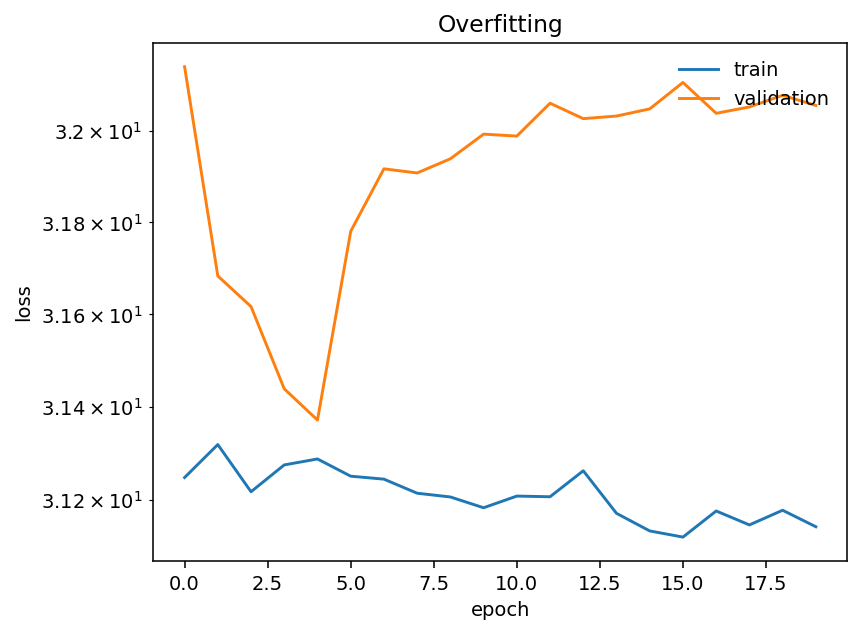

In [32]:
plt.plot(history.history['loss'],label="train")
plt.plot(history.history['val_loss'],label="validation")
plt.title('Overfitting') #Ran ~40 epochs before, then an extra 20
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper right',frameon = False)
plt.show()

(107889, 4, 3) (107889, 12) (107889, 12)


Text(0.5, 1.0, '1st Jet')

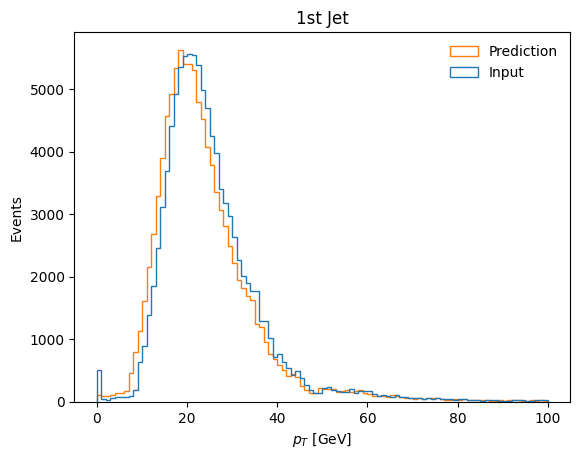

In [32]:
decoded_data = output.reshape(output.shape[0], 4,3) # Do the three dimensions correspond to the three variables? Bc I feel like no
data_valid_reshaped = data_valid.reshape(data_valid.shape[0], 4,3)

print(decoded_data.shape,data_test.shape, data_valid.shape)

#Jet Pt plot
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,0,0],decoded_data[:,0,0]],bins=100,histtype='step',range = (0,100), label = ['Input','Prediction'])
plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')


## Patience, learning rate, and the size of the neural network
**Patience**
- Small value: Put patience at 1 and ran it for 50 epochs and it still didn't stop! Better loss curve and good fit between prediction and data. In theory, a low patience value stops once there's no sign of improvement.
- Large value: A high patience value means that it will run through a higher number of epochs, even if it's not improving. This can lead to overtraining.
  
**Learning rate**
- Small value: Set to 0.000001, stopped after 6 epochs with a patience of 5. Validation loss started to increase, which is a sign of overfitting. 
- Large value: Set at 0.1. Stopped after 5 epochs with a patience of 5, couldn't produce loss or prediction graphs.

**Size of NN**
- Small value: Removed x2 and x3 in encoder and x6 and x7 in decoder. Poorer correlation, but not as bad as I would've assumed.
- Large value: Added 2 encoding layers and 1 decoding layer, seen below. Predictions improved, although loss curve still looks a little strange (likely would improve with > 20 epochs).

In [70]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        print(batch)
        dim = tf.shape(z_mean)[1]
        print(dim)
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
#Encoder

latent_dim = 4

encoder_inputs = keras.Input(shape=(12))
x = layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = False)(encoder_inputs)
xa = layers.Dense(128, activation="relu")(x)
xb = layers.Dense(64, activation="relu")(xa)
x1 = layers.Dense(32, activation="relu")(xb)
x2 = layers.Dense(16, activation="relu")(x1)
x3 = layers.Dense(8, activation="relu")(x2)
z_mean = layers.Dense(latent_dim, name="z_mean")(x1)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x1)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

#Decoder

latent_inputs = keras.Input(shape=(latent_dim,))
x4 = layers.Dense(16, activation="relu")(latent_inputs)
norm_layer_1 = layers.BatchNormalization(name="norm_1")(x4)
x5 = layers.Dense(32, activation="relu")(norm_layer_1)
norm_layer_2 = layers.BatchNormalization(name="norm_2")(x5)
x6 = layers.Dense(64, activation="relu")(norm_layer_2)
norm_layer_3 = layers.BatchNormalization(name="norm_3")(x6)
x7 = layers.Dense(128, activation="relu")(norm_layer_3)
norm_layer_4 = layers.BatchNormalization(name="norm_4")(x7)
x7a = layers.Dense(256, activation="relu")(norm_layer_4)
x8 = layers.Dense(12,kernel_initializer='zeros', activation='linear')(x5)
decoder_outputs = tf.keras.layers.Normalization(mean=np.mean(data_train,axis=0),variance=np.std(data_train,axis=0), axis=-1, invert = True)(x8)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

#Build Model

class VAE(keras.Model):
    def __init__(self, encoder, decoder,alpha = 1, beta = 0.001, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        self.reco_scale = alpha * (1 - beta)
        self.kl_scale = beta
        
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.total_val_loss_tracker = keras.metrics.Mean(name="total_val_loss")
        self.reconstruction_val_loss_tracker = keras.metrics.Mean(name="val_reco_loss")
        self.kl_val_loss_tracker = keras.metrics.Mean(name="val_kl_loss")


    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    

    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            
            #MSE = keras.losses.MeanSquaredLogarithmicError(reduction="auto", name="mean_squared_error")
            #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
            MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
            reconstruction_loss = self.reco_scale * tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
            
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        
        grads = tape.gradient(total_loss, self.trainable_weights)

        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
            
        z_mean, z_log_var, z = self.encoder(data)
        reconstruction = self.decoder(z)
        
        #MSE = keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error")
        MSE = keras.losses.MeanSquaredError(reduction="none", name="mean_squared_error")
        reconstruction_loss = self.reco_scale* tf.reduce_mean(tf.reduce_sum(MSE(data,reconstruction)))
                    
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = self.kl_scale * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        
        total_loss = reconstruction_loss + kl_loss
        
        self.total_val_loss_tracker.update_state(total_loss)
        self.reconstruction_val_loss_tracker.update_state(reconstruction_loss)
        self.kl_val_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_val_loss_tracker.result(),
            "reco_loss": self.reconstruction_val_loss_tracker.result(),
            "kl_loss": self.kl_val_loss_tracker.result()

      }

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0, patience=5, verbose = 1,restore_best_weights=True)
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.0001,clipnorm=10.0))
history = vae.fit(data_train, validation_data = (data_valid, data_valid), epochs=20, batch_size=16, callbacks = [callback],shuffle=False)

Tensor("sampling_17/strided_slice:0", shape=(), dtype=int32)
Tensor("sampling_17/strided_slice_1:0", shape=(), dtype=int32)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_40 (InputLayer)          [(None, 12)]         0           []                               
                                                                                                  
 normalization_38 (Normalizatio  (None, 12)          0           ['input_40[0][0]']               
 n)                                                                                               
                                                                                                  
 dense_133 (Dense)              (None, 128)          1664        ['normalization_38[0][0]']       
                                                                   

In [71]:
z_mean, z_log_var, z = vae.encoder.predict(data_valid)
output = vae.decoder.predict(z)

Tensor("encoder/sampling_17/strided_slice:0", shape=(), dtype=int32)
Tensor("encoder/sampling_17/strided_slice_1:0", shape=(), dtype=int32)
3372/3372 [==============================] - 2s 610us/step


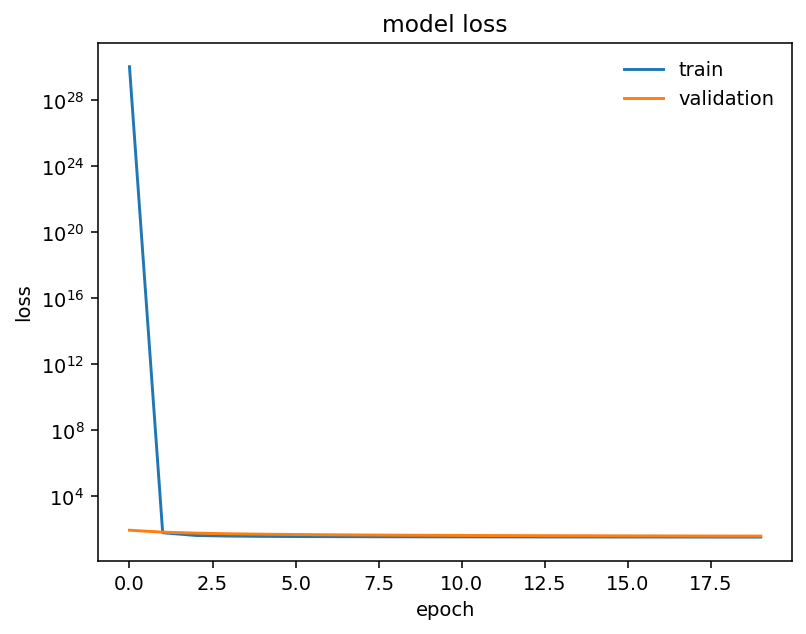

Text(0.5, 1.0, '1st Jet')

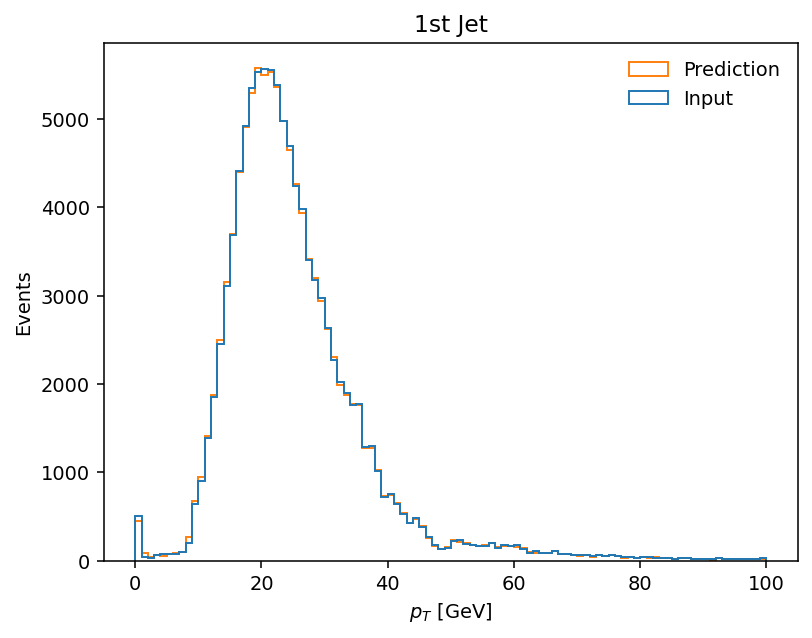

In [72]:
plt.plot(history.history['loss'],label="train")
plt.plot(history.history['val_loss'],label="validation")
plt.title('model loss')
plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend( loc='upper right',frameon = False)
plt.show()

decoded_data = output.reshape(output.shape[0], 4,3) # Do the three dimensions correspond to the three variables? Bc I feel like no
data_valid_reshaped = data_valid.reshape(data_valid.shape[0], 4,3)

#print(decoded_data.shape,data_test.shape, data_valid.shape)

#Jet Pt plot
plt.figure()
plt.rcParams['figure.dpi'] = 140
plt.hist([data_valid_reshaped[:,0,0],decoded_data[:,0,0]],bins=100,histtype='step',range = (0,100), label = ['Input','Prediction'])
plt.xlabel(r"$p_T$ [GeV]")
plt.ylabel("Events")
plt.legend(frameon = False)
plt.title('1st Jet')

## 2D Histograms of Loss vs. Objects
I do not need to alter anything in the NN! All of the work that is below is after running the original configuration that I was given. 

In [10]:
# Manually calculating the reconstruction loss
reco_loss_pt = []
for i in range(decoded_data.shape[0]):
    pred = decoded_data[i, 0, 0:2]
    real = data_valid_reshaped[i, 0, 0:2]
    mse = np.mean((real - pred)**2) # Just looking at error between 2 events, don't worry about taking mean of more samples - only helpful for network 
    reco_loss_pt.append(mse)


Text(0, 0.5, 'Events')

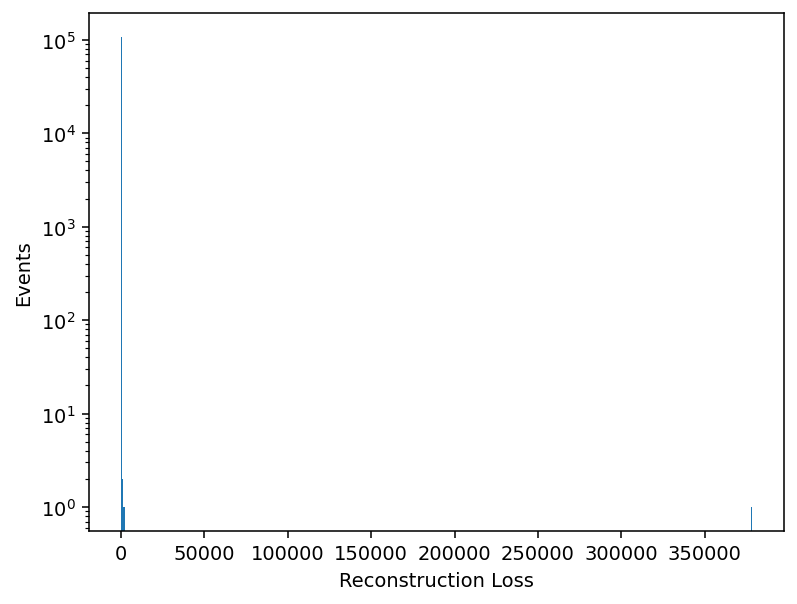

In [11]:
# Let's look at the error - the point over at 4000 is likely anomalous, because the VAE did such an awful job of encoding it
plt.hist(reco_loss_pt,bins=500)
plt.yscale("log")
plt.xlabel("Reconstruction Loss")
plt.ylabel("Events")

In [34]:
# What event caused that outlier?
reco_loss_pt = np.array(reco_loss_pt)
mask = np.array(reco_loss_pt) > 2000
print(decoded_data[mask])
print(data_valid_reshaped[mask])
# We see really big pT values which often corresponds to an anomalous event

[[[ 9.57169556e+02  1.02926483e+02  1.01672357e+03]
  [-2.37651100e+01 -3.45103323e-01  5.95292330e-01]
  [-5.51906526e-01  8.15953195e-01  1.07887626e-01]
  [ 2.50717998e+00 -4.76481944e-01  2.76309013e+00]]]
[[[ 1.02350000e+03  1.80000000e+01  1.02350000e+03]
  [ 2.75000000e+01  1.87060547e+00 -8.26538086e-01]
  [ 1.87060547e+00 -2.39257812e+00  6.52465820e-01]
  [-2.75976562e+00  6.52465820e-01 -6.26831055e-02]]]


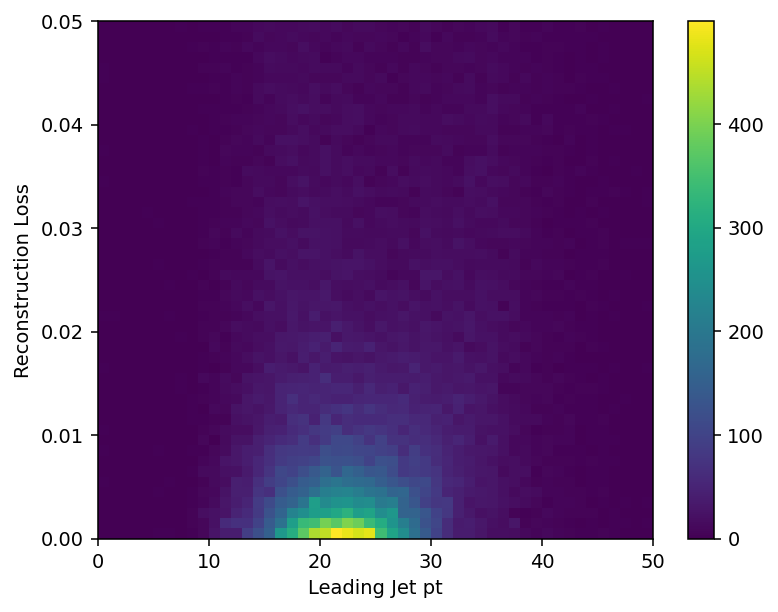

In [15]:
leading_jet_pt = data_valid_reshaped[:,0,0]
plt.hist2d(leading_jet_pt, reco_loss_pt,bins=50,range=[(0,50),(0,0.05)])

#plt.yscale("log")
plt.ylabel("Reconstruction Loss")
plt.xlabel("Leading Jet pt")
plt.colorbar()

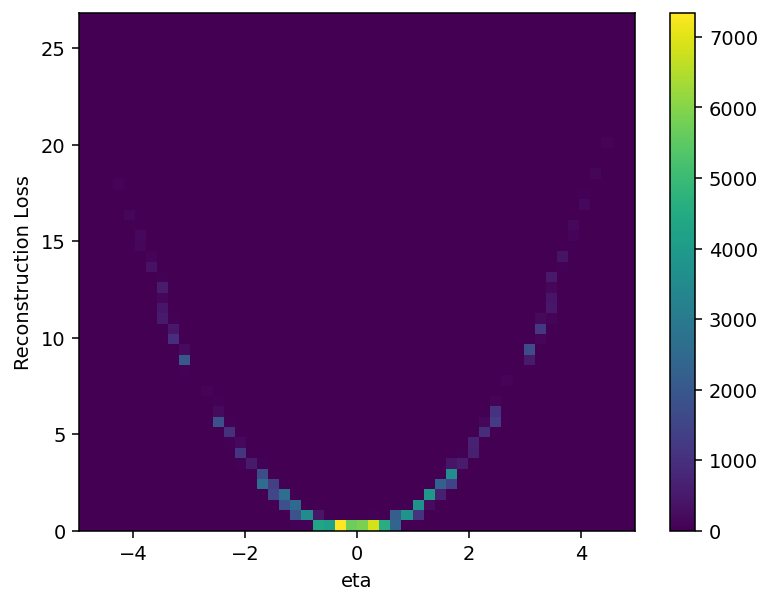

In [16]:
# Now let's look at eta
reco_loss_eta = []
for i in range(decoded_data.shape[0]):
    pred = decoded_data[i, 1, 1]
    real = data_valid_reshaped[i, 1, 1]
    mse = (real - pred)**2 
    reco_loss_eta.append(mse)

eta = data_valid_reshaped[:,1,1]
plt.hist2d(eta, reco_loss_eta, bins=50)

#plt.yscale("log")
plt.ylabel("Reconstruction Loss")
plt.xlabel("eta")
plt.colorbar()

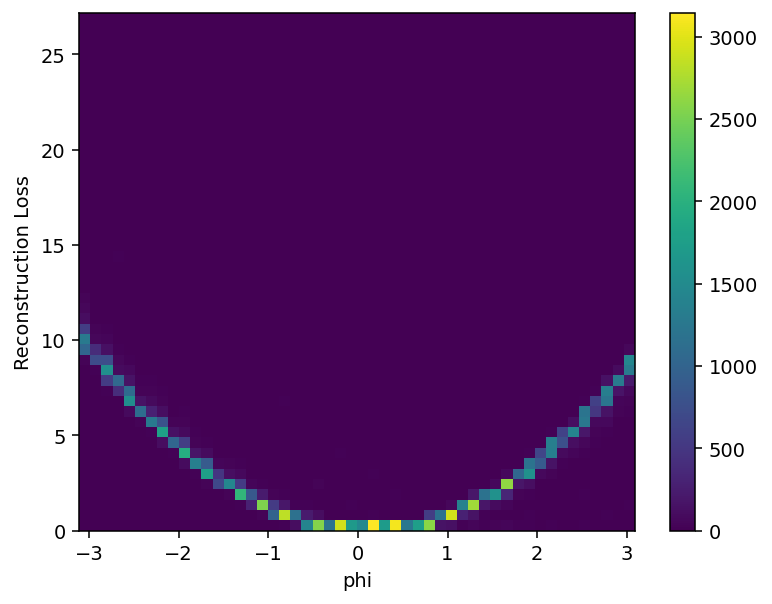

In [17]:
# And for phi
reco_loss_phi = []
for i in range(decoded_data.shape[0]):
    pred = decoded_data[i, 2, 2]
    real = data_valid_reshaped[i, 2, 2]
    mse = (real - pred)**2 
    reco_loss_phi.append(mse)

phi = data_valid_reshaped[:,2,2]
plt.hist2d(phi, np.array(reco_loss_phi), bins=50)

#plt.yscale("log")
plt.ylabel("Reconstruction Loss")
plt.xlabel("phi")
plt.colorbar()

#eta and phi both have interesting shapes?

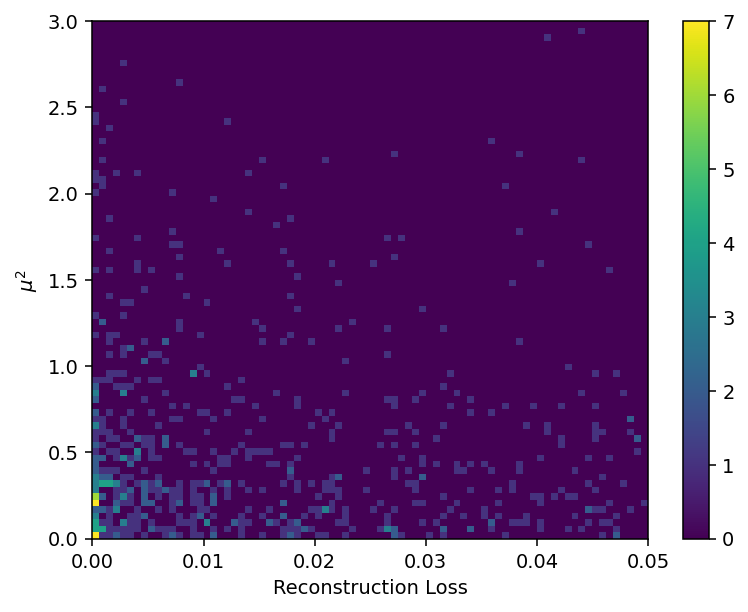

In [33]:
# Now we look at mu^2 vs. loss

mu_2 = (z_mean[:,0])**2 # Mean of the latent distribution --> kl_loss uses this!
plt.hist2d(mu_2, reco_loss_pt, bins=80, range=([0,0.05],[0,3]))
plt.ylabel(r"${\mu}^2$")
plt.xlabel("Reconstruction Loss")
plt.colorbar()